### Dpi Setting

In [82]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


# Dependencies

### Python

In [85]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [86]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [87]:
from rpy2.robjects.packages import importr


In [88]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [89]:
%%R

if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

### Imports

In [90]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

## Functions

### Scores in R

In [91]:
def scores(coords, probs, n, N, sample_idx):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N

    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]

    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[1][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

# Handpicked Cases

## Linear 1D

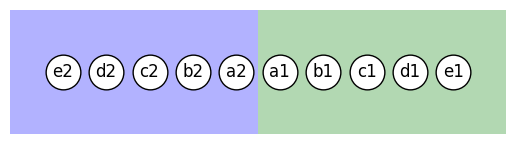

   Sample   # Density Voronai  Moran Local Balance
0   ai aj   1    0.14     0.0  -0.25          0.49
1   ai bi   2    0.14    0.04  -0.06          0.55
2   ai bj   2    0.11    0.04  -0.17          0.39
3   ai ci   2    0.11    0.04    0.0          0.52
4   ai cj   2    0.07    0.04  -0.79          0.36
5   ai di   2    0.07    0.16  -0.24          0.59
6   ai dj   2    0.02    0.16  -0.84          0.47
7   ai ei   2    0.02    0.25   -0.2          0.71
8   ai ej   2     0.0    0.16   -1.0          0.58
9   bi bj   1    0.07     0.0  -0.79          0.25
10  bi ci   2    0.14    0.16   0.06          0.69
11  bi cj   2    0.02    0.01  -0.84          0.18
12  bi di   2    0.11    0.36   0.13          0.76
13  bi dj   2     0.0    0.04   -1.0          0.28
14  bi ei   2    0.07    0.36  -0.13          0.85
15  bi ej   2    0.03    0.04  -0.76          0.42
16  ci cj   1     0.0     0.0   -1.0           0.0
17  ci di   2    0.14    0.36   0.19          0.89
18  ci dj   2    0.03    0.01  

In [92]:
points = {
    (0.35,): "a1",
    (-0.35,): "a2",
    (1.05,): "b1",
    (-1.05,): "b2",
    (1.75,): "c1",
    (-1.75,): "c2",
    (2.45,): "d1",
    (-2.45,): "d2",
    (3.15,): "e1",
    (-3.15,): "e2",
}

N = len(points)
n = 2
coords = np.array(list(points.keys()))
probs = rng.equal_probabilities(n, N)
fig, ax = plt.subplots()
for (x,), label in points.items():
    ax.plot(x, 0, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, 0, label, color="black", ha="center", va="center", fontsize=12)
ax.set_xlim(-4, 4)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
ax.axis("off")
ax.axvspan(0, 4, facecolor='green', alpha=0.3)
ax.axvspan(-4, 0, facecolor='blue', alpha=0.3)

plt.show()

dic_score = {}
for i, j in combinations(range(0, N), 2):
    i_label, j_label = points[tuple(coords[i])], points[tuple(coords[j])]
    if i_label[1] == j_label[1]:
        identifier = f"{i_label[0]}i {j_label[0]}i"
    else:
        identifier = f"{i_label[0]}i {j_label[0]}j"
    sample_idx = np.array([i, j])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 2)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.round(np.mean(all_scores, axis=0), 2)


result.append(
    np.concatenate([["Mean", len(all_scores)], overall_mean])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])
# print(df.to_latex(index=False))
print(df)

## 4 3x3

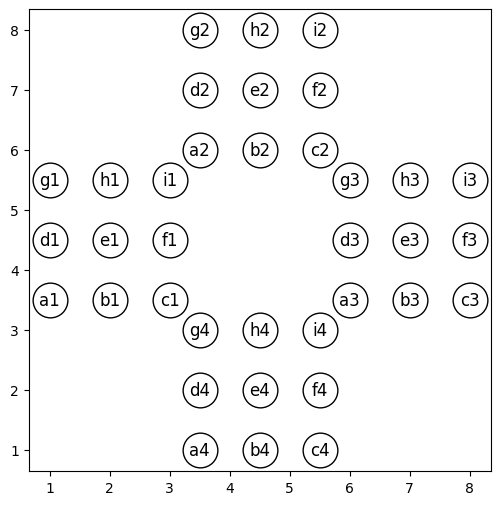

,Sample,Density,Voronai,Moran,Local Balance
0,e1 e2 e3 e4,0.00,0.00,-1.00,0.00
1,a1 a2 a3 a4,0.00,0.11,-0.59,0.43
2,d1 d2 d3 d4,0.00,0.02,-0.83,0.28
3,b1 d2 h3 f4,0.02,0.00,-0.75,0.19
4,f1 b2 d3 h4,0.33,0.00,-0.69,0.26
5,d1 h2 f3 b4,0.40,0.00,-0.50,0.26
6,a1 c1 g1 i1,0.34,0.56,0.38,0.84
7,b1 d1 f1 h1,0.48,0.56,0.52,0.79
8,h1 d2 b3 f4,0.03,0.00,-0.00,0.26


\begin{tabular}{llllll}
\toprule
 & Sample & Density & Voronai & Moran & Local Balance \\
\midrule
0 & e1 e2 e3 e4 & 0.00 & 0.00 & -1.00 & 0.00 \\
1 & a1 a2 a3 a4 & 0.00 & 0.11 & -0.59 & 0.43 \\
2 & d1 d2 d3 d4 & 0.00 & 0.02 & -0.83 & 0.28 \\
3 & b1 d2 h3 f4 & 0.02 & 0.00 & -0.75 & 0.19 \\
4 & f1 b2 d3 h4 & 0.33 & 0.00 & -0.69 & 0.26 \\
5 & d1 h2 f3 b4 & 0.40 & 0.00 & -0.50 & 0.26 \\
6 & a1 c1 g1 i1 & 0.34 & 0.56 & 0.38 & 0.84 \\
7 & b1 d1 f1 h1 & 0.48 & 0.56 & 0.52 & 0.79 \\
8 & h1 d2 b3 f4 & 0.03 & 0.00 & -0.00 & 0.26 \\
\bottomrule
\end{tabular}



In [93]:
samples = np.array([
    ["e1", "e2", "e3", "e4"],
    ["a1", "a2", "a3", "a4"],
    ["d1", "d2", "d3", "d4"],
    ["f4", "h3", "d2", "b1"],
    ["f1", "b2", "d3", "h4"],
    ["f3", "d1", "b4", "h2"],
    ["a1", "c1", "g1", "i1"],
    ["b1", "d1", "f1", "h1"],
    #### NEW Interstings
    "h1 d2 b3 f4".split(" "),
])

x3coords = rng.grid_coordinates((3, 2)) * 2
x3probs = rng.equal_probabilities(1, 9)

left = x3coords.copy()
right = x3coords.copy()
up = x3coords.copy()
down = x3coords.copy()

left_labels = [chr(ord('a') + i) + '1' for i in range(9)]
right_labels = [chr(ord('a') + i) + '3' for i in range(9)]
up_labels = [chr(ord('a') + i) + '2' for i in range(9)]
down_labels = [chr(ord('a') + i) + '4' for i in range(9)]

####### TEST
import itertools
# samples = np.array([
#     [l, u, r, d]
#     for l, u, r, d in itertools.product(left_labels, up_labels, right_labels, down_labels)
# ])
#######

left[:, 0] += 1
left[:, 1] += 3.5
right[:, 0] += 6
right[:, 1] += 3.5
up[:, 0] += 3.5
up[:, 1] += 6
down[:, 0] += 3.5
down[:, 1] += 1


coords = np.vstack([left, right, up, down])
probs = np.concatenate([x3probs, x3probs, x3probs, x3probs])
labels = np.concatenate([left_labels, right_labels, up_labels, down_labels])
label_to_idx = {l: idx for idx, (c, l) in enumerate(zip(coords, labels))}
assert len(probs) == len(coords) == len(labels)

N = len(coords)
n = 4
points = {}
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
for (x, y), label in zip(coords, labels):
    points[label] = (x, y)
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', label=1, markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

plt.show()

results = []
for sample in samples:
    sample_idx = np.array([label_to_idx[s] for s in sample])
    identifier = " ".join(sorted(sample, key=lambda x: x[1]))
    s = scores(coords, probs, n, N, sample_idx)
    s_formatted = [f"{num:.2f}" for num in s]  # Corrected line
    results.append([identifier] + s_formatted)

df = pd.DataFrame(results, columns=["Sample", "Density", "Voronai", "Moran", "Local Balance"])
display(df)
print(df.to_latex())


## Rotating

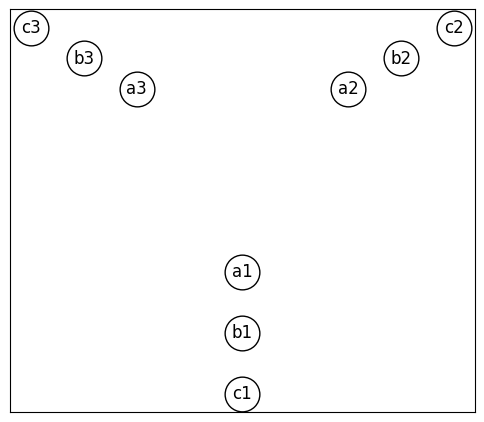

,Sample,#,Density,Voronai,Moran,Local Balance
0,aaa,1,0.56,0.0,-1.0,0.263
1,aab,3,0.3,0.0,-1.0,0.214
2,aac,3,0.141,0.0,-1.0,0.263
3,abb,3,0.101,0.0,-1.0,0.152
4,abc,6,0.045,0.0,-1.0,0.214
5,acc,3,0.039,0.0,-1.0,0.263
6,bbb,1,0.0,0.0,-1.0,0.0
7,bbc,3,0.067,0.0,-1.0,0.152
8,bcc,3,0.161,0.0,-1.0,0.214
9,ccc,1,0.223,0.0,-1.0,0.263


In [94]:
def rotate_point(p, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.array([
        p[0] * cost - p[1] * sint,
        p[0] * sint + p[1] * cost
    ])

def rotate_matrix(matrix, t, cost=None, sint=None):
    if cost is None or sint is None:
        cost, sint = np.cos(t), np.sin(t)
    return np.apply_along_axis(rotate_point, 1, matrix, t, cost, sint)

template = np.array([
    [0.0, -0.5],
    [0.0, -1],
    [0.0, -1.5]
])
template = np.array([
    [0.0, -2],
    [0.0, -3],
    [0.0, -4]
])

angles = np.arange(0, 3) * (2.0 * np.pi / 3.0)
pop = np.vstack([rotate_matrix(template, angle) for angle in angles])

all_points = pop
labels = ["a1", "b1", "c1", "a2", "b2", "c2", "a3", "b3", "c3"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

for (x, y), label in zip(all_points, labels):
    ax.plot(x, y, 'o', markersize=25, markerfacecolor='white', markeredgecolor='black', markeredgewidth=1)
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

N = len(all_points)
n = 3
coords = np.array(all_points)
probs = rng.equal_probabilities(n, N)

from itertools import combinations, combinations_with_replacement

dic_score = {}
for i, j, k in combinations(range(0, N), 3):
    i_label, j_label, k_label = labels[i], labels[j], labels[k]
    ids = list(sorted([i_label[0], j_label[0], k_label[0]]))
    identifier = "".join(ids)

    if len(set([i_label[1], j_label[1], k_label[1]])) != n:
      continue

    sample_idx = np.array([i, j, k])
    dic_score.setdefault(identifier, [])
    dic_score[identifier].append(np.array(scores(coords, probs, n, N, sample_idx)))

result = []
for i, s in dic_score.items():
    ss = np.round(np.mean(s, axis=0), 3)
    row = np.concatenate([[i, len(s)], ss])
    result.append(row)

all_scores = np.concatenate([s for s in dic_score.values()])
overall_mean = np.mean(all_scores, axis=0)


result.append(
    np.concatenate([["Mean", len(all_scores)], np.round(overall_mean, 2)])
)

df = pd.DataFrame(result, columns=["Sample", "#", "Density", "Voronai", "Moran", "Local Balance"])

display(df)
# print(df.to_latex())

# Simulations

## Methods

In [95]:
def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    return gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=n_zones, tolerance=5).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
        mask <- UPmaxentropy(probs)
        """
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

    return np.array(samples)


def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx


def find_samples(coords, probs, n, num_samples):
    return {
        "K-Means (2, 2)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        "K-Means (5, 5)": k_means_samples(coords, probs, n, num_samples, (3, 3)),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
    }

In [96]:
import time
def find_samples(coords, probs, n, num_samples):
    results = {}

    start = time.time()
    results["K-Means (2, 2)"] = k_means_samples(coords, probs, n, num_samples, (2, 2))
    print(f"K-Means (2, 2): {time.time() - start:.3f} seconds")

    start = time.time()
    results["K-Means (5, 5)"] = k_means_samples(coords, probs, n, num_samples, (5, 5))
    print(f"K-Means (5, 5): {time.time() - start:.3f} seconds")

    start = time.time()
    results["Local Pivotal"] = local_pivotal_samples(coords, probs, n, num_samples)
    print(f"Local Pivotal: {time.time() - start:.3f} seconds")

    start = time.time()
    results["Random"] = random_samples(coords, probs, n, num_samples)
    print(f"Random: {time.time() - start:.3f} seconds")

    start = time.time()
    results["UPmaxentropy"] = upmaxentropy_samples(probs, num_samples)
    print(f"UPmaxentropy: {time.time() - start:.3f} seconds")

    # If you want to test wave_samples, uncomment and add timing as above
    # start = time.time()
    # results["Wave"] = wave_samples(coords, probs, n, num_samples)
    # print(f"Wave: {time.time() - start:.3f} seconds")

    return results

## Initial Population

In [97]:
n = 5 # Number of item in each sample (number of clusters)
sample_cnt = 20 # How many sample gather from each desiging method

### Coords

Uncomment each one you would like to get result from

In [98]:
swiss = 0
######### GRID
# grid_size = 20
# N = grid_size**2
# coords = rng.grid_coordinates((grid_size, 2))


######### RANDOM
N = 500
coords = rng.random_coordinates((N, 2))
idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]

######### CLUSTRED
n_clusters = 4
cluster_std = 0.05
# N = 400
coords = rng.cluster_coordinates(n_clusters, cluster_std, (N, 2))


######### SWISS: https://docs.google.com/spreadsheets/d/10uYLsZpxRV5lUrsGfy3gI0RD4fAn8lIP/edit?usp=sharing&ouid=117333816980669142577&rtpof=true&sd=true
swiss = 1
swiss_df = pd.read_csv('/home/divar/projects/geometric-sampling/swiss.csv')
coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
swiss_df['AREA'] = swiss_df['AREA'].clip(lower=1, upper=20)
N = len(coords)




idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]


### Probabilities

Uncomment each one you would like to get result from

In [99]:
######### EQUAL
probs = rng.equal_probabilities(n, N)


######### UNEQUAL
probs = np.sort(rng.unequal_probabilities(n, N))
probs = np.sort(rng.unequal_probabilities(n, N))[::-1]                                                          
# if swiss == 1:
#     probs = inclusion_probabilities(swiss_df['AREA'].to_numpy(), n)


## Results

### Plotting coords

Plotting clusters: 100%|██████████| 5/5 [00:00<00:00, 185.18it/s]


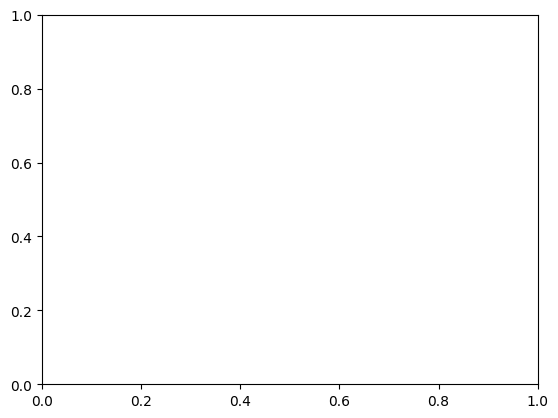

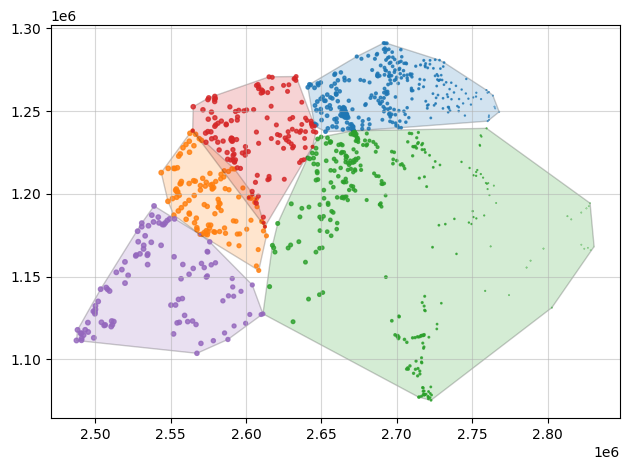

Sum of probs per cluster:
  Cluster 0: 1.0047
  Cluster 1: 1.0213
  Cluster 2: 1.0156
  Cluster 3: 1.0390
  Cluster 4: 1.0077


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from tqdm import tqdm

# ---- define your plot_convex_hull as before ----
def plot_convex_hull(
        points, ax, color, alpha=0.3, edge_color="black", line_width=1.0
    ):
        if len(points) < 3:
            return ax, None
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
        )
        ax.add_patch(polygon)
        return ax, hull

density_measure = gs.measure.Density(coords, probs, n)
clusters, centroids = density_measure.clusters, density_measure.centroids
fig, ax = plt.subplots()
cluster_sizes = []
probs_sums = []

fig, ax = plt.subplots()

for cluster_idx, cluster in tqdm(enumerate(clusters), total=len(clusters), desc="Plotting clusters"):
    cluster_points = cluster[:, 1:3]
    cluster_indices = cluster[:, 0].astype(int)  # assuming first column in cluster is the index

    # Summing probs
    probs_sum = probs[cluster_indices].sum()
    probs_sums.append(probs_sum)

    # Plotting
    cmap = plt.get_cmap('tab10')         
    n_colors = cmap.N                  
    cluster_color = cmap(cluster_idx % n_colors)    
    
    ax, hull = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
    
    ax.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=cluster_color,
        s=cluster[:, 3] * 1000,
        alpha=0.8,
    )
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

print("Sum of probs per cluster:")
for idx, prob_sum in enumerate(probs_sums):
    print(f"  Cluster {idx}: {float(prob_sum):.4f}")

### Gathering Data

In [101]:
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

sample_methods = find_samples(coords, probs, n, sample_cnt)

rows = np.array([
    [method, *scores(coords, probs, n, N, s)]
    for method, samples in sample_methods.items()
    for s in tqdm(samples, total=sample_cnt)
])

df = pd.DataFrame(rows, columns=columns)
df = df.astype({
    "Density": float,
    "Voronoi": float,
    "Moran": float,
    "Local Balance": float
})


Iteration 0
Ti: [1.38972261 0.88263188 0.81774723 0.9696917  0.94020658]
Sum Ti: 5.000000000000001

Iteration 1
Ti: [1.36204744 0.94055547 0.89225839 0.94055547 0.86458323]
Sum Ti: 5.000000000000001

Iteration 2
Ti: [1.13060207 0.92616046 1.13060207 0.94055547 0.87207994]
Sum Ti: 5.000000000000001

Iteration 3
Ti: [1.13060207 1.01764425 1.04586061 0.93381313 0.87207994]
Sum Ti: 5.000000000000002

Iteration 4
Ti: [1.06718797 1.05973099 1.06718797 0.93381313 0.87207994]
Sum Ti: 5.000000000000002

Iteration 5
Ti: [1.06433692 1.04543593 1.06345948 0.95183668 0.87493099]
Sum Ti: 5.000000000000002

Iteration 6
Ti: [1.06433692 1.0544477  1.0544477  0.95183668 0.87493099]
Sum Ti: 5.000000000000002

Iteration 7
Ti: [1.04323651 1.02659789 1.05939231 0.97968649 0.89108679]
Sum Ti: 5.000000000000002

Iteration 8
Ti: [1.04323651 1.0429951  1.0429951  0.97968649 0.89108679]
Sum Ti: 5.000000000000003

Iteration 9
Ti: [1.00411193 1.0429951  1.0429951  0.97968649 0.93021137]
Sum Ti: 5.0000000000000036

100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


# Bardia Simu

In [102]:
%load_ext autoreload
%autoreload 2
import geometric_sampling as gs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1. Initialize samplers ONCE, with all zoning/clustering prepped in advance (fast!)
kmeans_samplers = {
    "K-Means (2, 2)": gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=(2, 2), tolerance=5),
    "K-Means (5, 5)": gs.sampling.KMeansSpatialSampling(coords, probs, n=n, n_zones=(5, 5), tolerance=5),
}

# You can put your other (non-kmeans) sampling methods in here with their function references
other_sample_methods = {
    "Local Pivotal": local_pivotal_samples,
    "Random": random_samples,
    "UPmaxentropy": upmaxentropy_samples,
    # "Wave": wave_samples,  # If needed
}

columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]
rows = []

# 2. Main loop: For each method, score each sample rapidly
for method, sampler in {**kmeans_samplers, **other_sample_methods}.items():
    # For k-means classes, use `.sample`, else call function
    if method in kmeans_samplers:
        samples = sampler.sample(sample_cnt)
    else:
        if method == "Local Pivotal":
            samples = sampler(coords, probs, n, sample_cnt)
        elif method == "Random":
            samples = sampler(coords, probs, n, sample_cnt)
        elif method == "UPmaxentropy":
            samples = sampler(probs, sample_cnt)
        # elif method == "Wave":
        #     samples = sampler(coords, probs, n, sample_cnt)
        else:
            continue

    # 3. Score all draws for this method
    for s in tqdm(samples, total=sample_cnt, desc=method):
        row = [method, *scores(coords, probs, n, N, s)]
        rows.append(row)

# 4. Build DataFrame of results 
df = pd.DataFrame(rows, columns=columns)
df = df.astype({
    "Density": float,
    "Voronoi": float,
    "Moran": float,
    "Local Balance": float
})

# DataFrame `df` now holds all your outcomes


Iteration 0
Ti: [1.38972261 0.9696917  0.94020658 0.88263188 0.81774723]
Sum Ti: 5.000000000000002

Iteration 1
Ti: [1.36204744 0.94055547 0.86458323 0.94055547 0.89225839]
Sum Ti: 5.000000000000001

Iteration 2
Ti: [1.13060207 0.94055547 0.87207994 0.92616046 1.13060207]
Sum Ti: 5.000000000000001

Iteration 3
Ti: [1.13060207 0.93381313 0.87207994 1.01764425 1.04586061]
Sum Ti: 5.000000000000002

Iteration 4
Ti: [1.06718797 0.93381313 0.87207994 1.05973099 1.06718797]
Sum Ti: 5.000000000000002

Iteration 5
Ti: [1.06433692 0.95183668 0.87493099 1.04543593 1.06345948]
Sum Ti: 5.000000000000002

Iteration 6
Ti: [1.06433692 0.95183668 0.87493099 1.0544477  1.0544477 ]
Sum Ti: 5.000000000000002

Iteration 7
Ti: [1.04323651 0.97968649 0.89108679 1.02659789 1.05939231]
Sum Ti: 5.000000000000002

Iteration 8
Ti: [1.04323651 0.97968649 0.89108679 1.0429951  1.0429951 ]
Sum Ti: 5.000000000000003

Iteration 9
Ti: [1.00411193 0.97968649 0.93021137 1.0429951  1.0429951 ]
Sum Ti: 5.000000000000003


Local Pivotal:   5%|▌         | 1/20 [00:11<03:32, 11.18s/it]

In [ ]:
import time

start = time.time()
samples = sampler.sample(sample_cnt)
print(f"Sampling time: {time.time() - start:.4f} seconds")

start = time.time()
for s in samples:
    row = [method, *scores(coords, probs, n, N, s)]
print(f"Scoring time: {time.time() - start:.4f} seconds")

Sampling time: 0.0047 seconds


KeyboardInterrupt: 

### Tables

Means

Describe

In [ ]:
#df.groupby("Method").std()
#df.groupby("Method").mean()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df.groupby("Method").describe())

Density                                                    \
                 count      mean       std       min       25%       50%   
Method                                                                     
K-Means (2, 2)    20.0  0.098994  0.072309  0.032602  0.070176  0.083049   
K-Means (5, 5)    20.0  0.122852  0.074400  0.018134  0.078614  0.099968   
Local Pivotal     20.0  0.163232  0.071228  0.059054  0.109916  0.146587   
Random            20.0  0.289169  0.098661  0.145422  0.214106  0.281522   
UPmaxentropy      20.0  0.254125  0.120684  0.100570  0.182799  0.218327   

                                   Voronoi                                \
                     75%       max   count      mean       std       min   
Method                                                                     
K-Means (2, 2)  0.105254  0.390711    20.0  0.178842  0.128920  0.039246   
K-Means (5, 5)  0.154918  0.297772    20.0  0.235165  0.143721  0.044036   
Local Pivotal   0.227576  0.309510    20.0  0.228411  0.135569  0.038309   
Random          0.343291  0.485277    20.0  0.587902  0.251896  0.074897   
UPmaxentropy    0.295086  0.557899    20.0  0.328169  0.245470  0.036409   

                                                       Moran            \
                     25%       50%       75%       max count      mean   
Method                                                                   
K-Means (2, 2)  0.073664  0.175622  0.240576  0.544812  20.0 -0.087752   
K-Means (5, 5)  0.112934  0.256767  0.280592  0.557080  20.0 -0.072655   
Local Pivotal   0.138371  0.192308  0.282659  0.521858  20.0 -0.059026   
Random          0.422422  0.609420  0.718335  1.055153  20.0 -0.021327   
UPmaxentropy    0.150777  0.226289  0.420035  0.936241  20.0 -0.023379   

                                                                            \
                     std       min       25%       50%       75%       max   
Method                                                                       
K-Means (2, 2)  0.033846 -0.146943 -0.107545 -0.088014 -0.076159 -0.026258   
K-Means (5, 5)  0.042244 -0.143919 -0.090406 -0.081655 -0.054023  0.002468   
Local Pivotal   0.034579 -0.093855 -0.086480 -0.071872 -0.034021  0.036112   
Random          0.028981 -0.072430 -0.041228 -0.021633 -0.001544  0.039884   
UPmaxentropy    0.040843 -0.087029 -0.047363 -0.023965  0.004104  0.066735   

               Local Balance                                           \
                       count      mean        std       min       25%   
Method                                                                  
K-Means (2, 2)          20.0  0.710409   0.691469  0.299804  0.436318   
K-Means (5, 5)          20.0  1.128277   1.618540  0.266131  0.441542   
Local Pivotal           20.0  0.707448   0.632133  0.324947  0.376169   
Random                  20.0  8.341011  16.316016  0.416519  0.572154   
UPmaxentropy            20.0  0.536049   0.309390  0.314150  0.410428   

                                               
                     50%       75%        max  
Method                                         
K-Means (2, 2)  0.489114  0.533871   2.791289  
K-Means (5, 5)  0.479920  1.122155   7.503269  
Local Pivotal   0.464986  0.563639   2.545302  
Random          1.632745  6.871265  63.305242  
UPmaxentropy    0.461300  0.511628   1.767720

### Plots

##### Color Pallet

In [ ]:
methods = df["Method"].unique()
method_palette = dict(zip(methods, sns.color_palette("Pastel1", n_colors=len(methods))))

##### Boxplot

In [ ]:
def remove_outliers(dataframe, column, IQR_coef, groupby_col=None):
    if groupby_col:
        def outlier_filter(group):
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - IQR_coef * IQR
            upper = Q3 + IQR_coef * IQR
            return group[(group[column] >= lower) & (group[column] <= upper)]

        return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
    else:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - IQR_coef * IQR
        upper = Q3 + IQR_coef * IQR
        return dataframe[(df[column] >= lower) & (dataframe[column] <= upper)]

    return df

/tmp/ipykernel_4504/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_4504/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dataframe.groupby(groupby_col, group_keys=False).apply(outlier_filter)
/tmp/ipykernel_4504/3298180823.py:11: DeprecationWarning: DataFrameGroupBy.apply opera

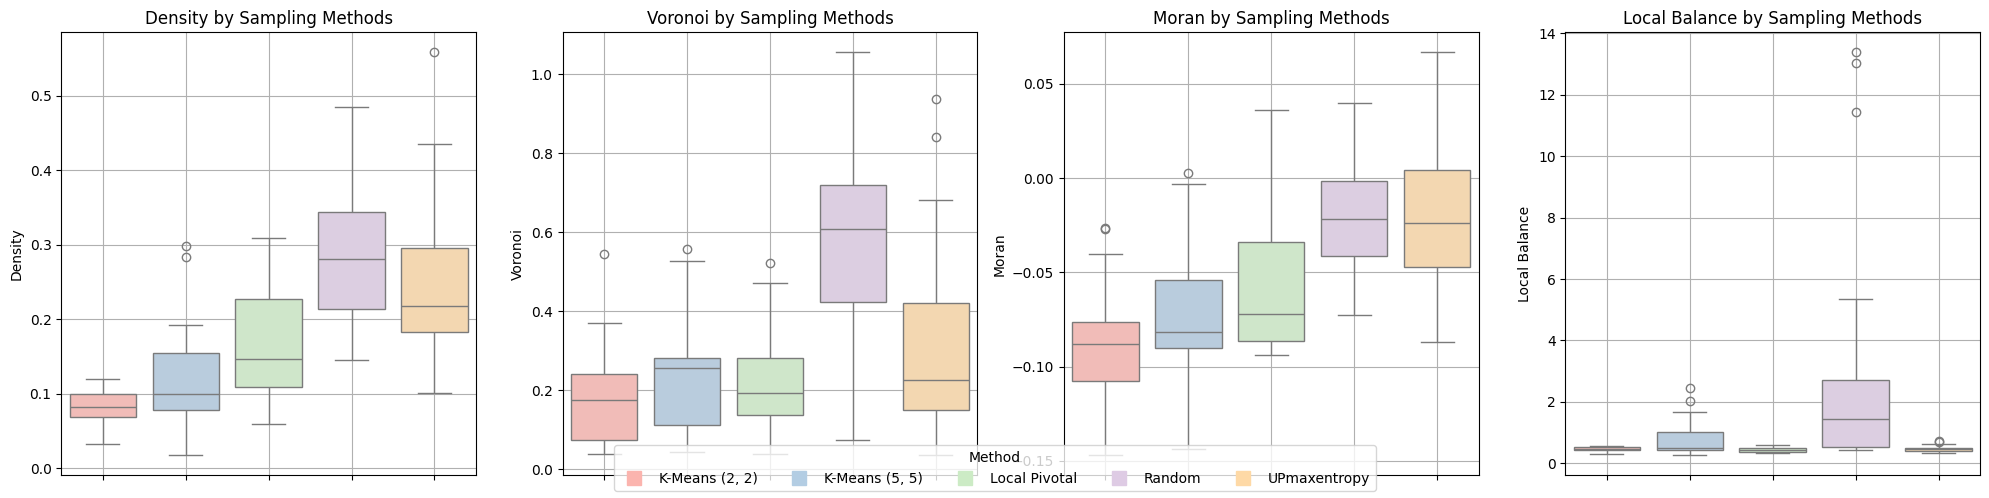

In [ ]:
number_of_items = len(columns[1:])
n_cols = 4  # how many plots per row
n_rows = (number_of_items + n_cols - 1) // n_cols  # compute needed rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

axes = axes.flatten()

for idx, column in enumerate(columns[1:]):
    sns.boxplot(x="Method", y=column, data=remove_outliers(df, column, IQR_coef=3, groupby_col="Method"), hue="Method", palette=method_palette, ax=axes[idx])
    axes[idx].set_title(f'{column} by Sampling Methods')
    axes[idx].set_xlabel("")
    axes[idx].set_xticklabels([])
    axes[idx].grid(True)

handles = [plt.Line2D([0], [0], color=color, marker='s', linestyle='', markersize=10, label=method) for method, color in method_palette.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(methods), fontsize=10, title="Method")

fig.tight_layout()
plt.show()